In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from funcs.pipe import extract

from astropy.io import fits

In [2]:

flux_label = r"Flux [e$^{-}$/s]"
time_label = "Time [BJD]"
files = np.loadtxt("files.txt", dtype=str)

In [3]:
# read cheops_flares file
flares = pd.read_csv("../results/cheops_flares.csv")

In [10]:
lcs = []
dlcs = []

for file in files:

    location = f"../data/hip67522/CHEOPS-products-{file}/Outdata/00000/{file}_detrended_lc.csv"

    dlcs.append(pd.read_csv(location))

    # file name
    IMG = f'../data/hip67522/CHEOPS-products-{file}/Outdata/00000/hip67522_CHEOPS-products-{file}_im.fits'

    # open the fits file
    hdulist = fits.open(IMG)
    print(f"Imagette file found for {file}:\n {IMG}\n")

    # get the image data
    image_data = hdulist[1].data


    # get LC data
    t, f, ferr, roll, dT, flag, bg, xc, yc = [extract(image_data, stri) for stri in ["BJD_TIME", "FLUX", "FLUXERR",
                                                                                    "ROLL", "thermFront_2", "FLAG",
                                                                                    "BG", "XC", "YC"]]

    # make sure the data is in fact 10s cadence
    assert np.diff(t).min() * 24 * 60 * 60 < 10.05, "Time series is not 10s cadence"

    # initial mask
    mask = (f < 2.96e6) & (f > 2.3e6) & (flag==0)
    print(f"Initial mask: {mask.sum()} data points")

    # apply the mask
    t, f, ferr, roll, dT, flag, bg, xc, yc = [arr[mask] for arr in [t, f, ferr, roll, dT, flag, bg, xc, yc]]

    lcs.append(pd.DataFrame({"time": t, "flux": f, "flux_err": ferr, "roll": roll, "dT": dT, "flag": flag, "bg": bg,
                                "xc": xc, "yc": yc}))
    

# make a list of the first time stamp in each lc in lcs
t0s = [lc["time"].min() for lc in lcs]

sorting = np.argsort(t0s)

lcs = [lcs[i] for i in sorting]
dlcs = [dlcs[i] for i in sorting]


Imagette file found for 20240319122713:
 ../data/hip67522/CHEOPS-products-20240319122713/Outdata/00000/hip67522_CHEOPS-products-20240319122713_im.fits

Initial mask: 2775 data points
Imagette file found for 20240603073928:
 ../data/hip67522/CHEOPS-products-20240603073928/Outdata/00000/hip67522_CHEOPS-products-20240603073928_im.fits

Initial mask: 2333 data points
Imagette file found for 20240522113135:
 ../data/hip67522/CHEOPS-products-20240522113135/Outdata/00000/hip67522_CHEOPS-products-20240522113135_im.fits

Initial mask: 2492 data points
Imagette file found for 20240412070023:
 ../data/hip67522/CHEOPS-products-20240412070023/Outdata/00000/hip67522_CHEOPS-products-20240412070023_im.fits

Initial mask: 3731 data points
Imagette file found for 20240311145359:
 ../data/hip67522/CHEOPS-products-20240311145359/Outdata/00000/hip67522_CHEOPS-products-20240311145359_im.fits

Initial mask: 2420 data points
Imagette file found for 20240312075007:
 ../data/hip67522/CHEOPS-products-20240312075

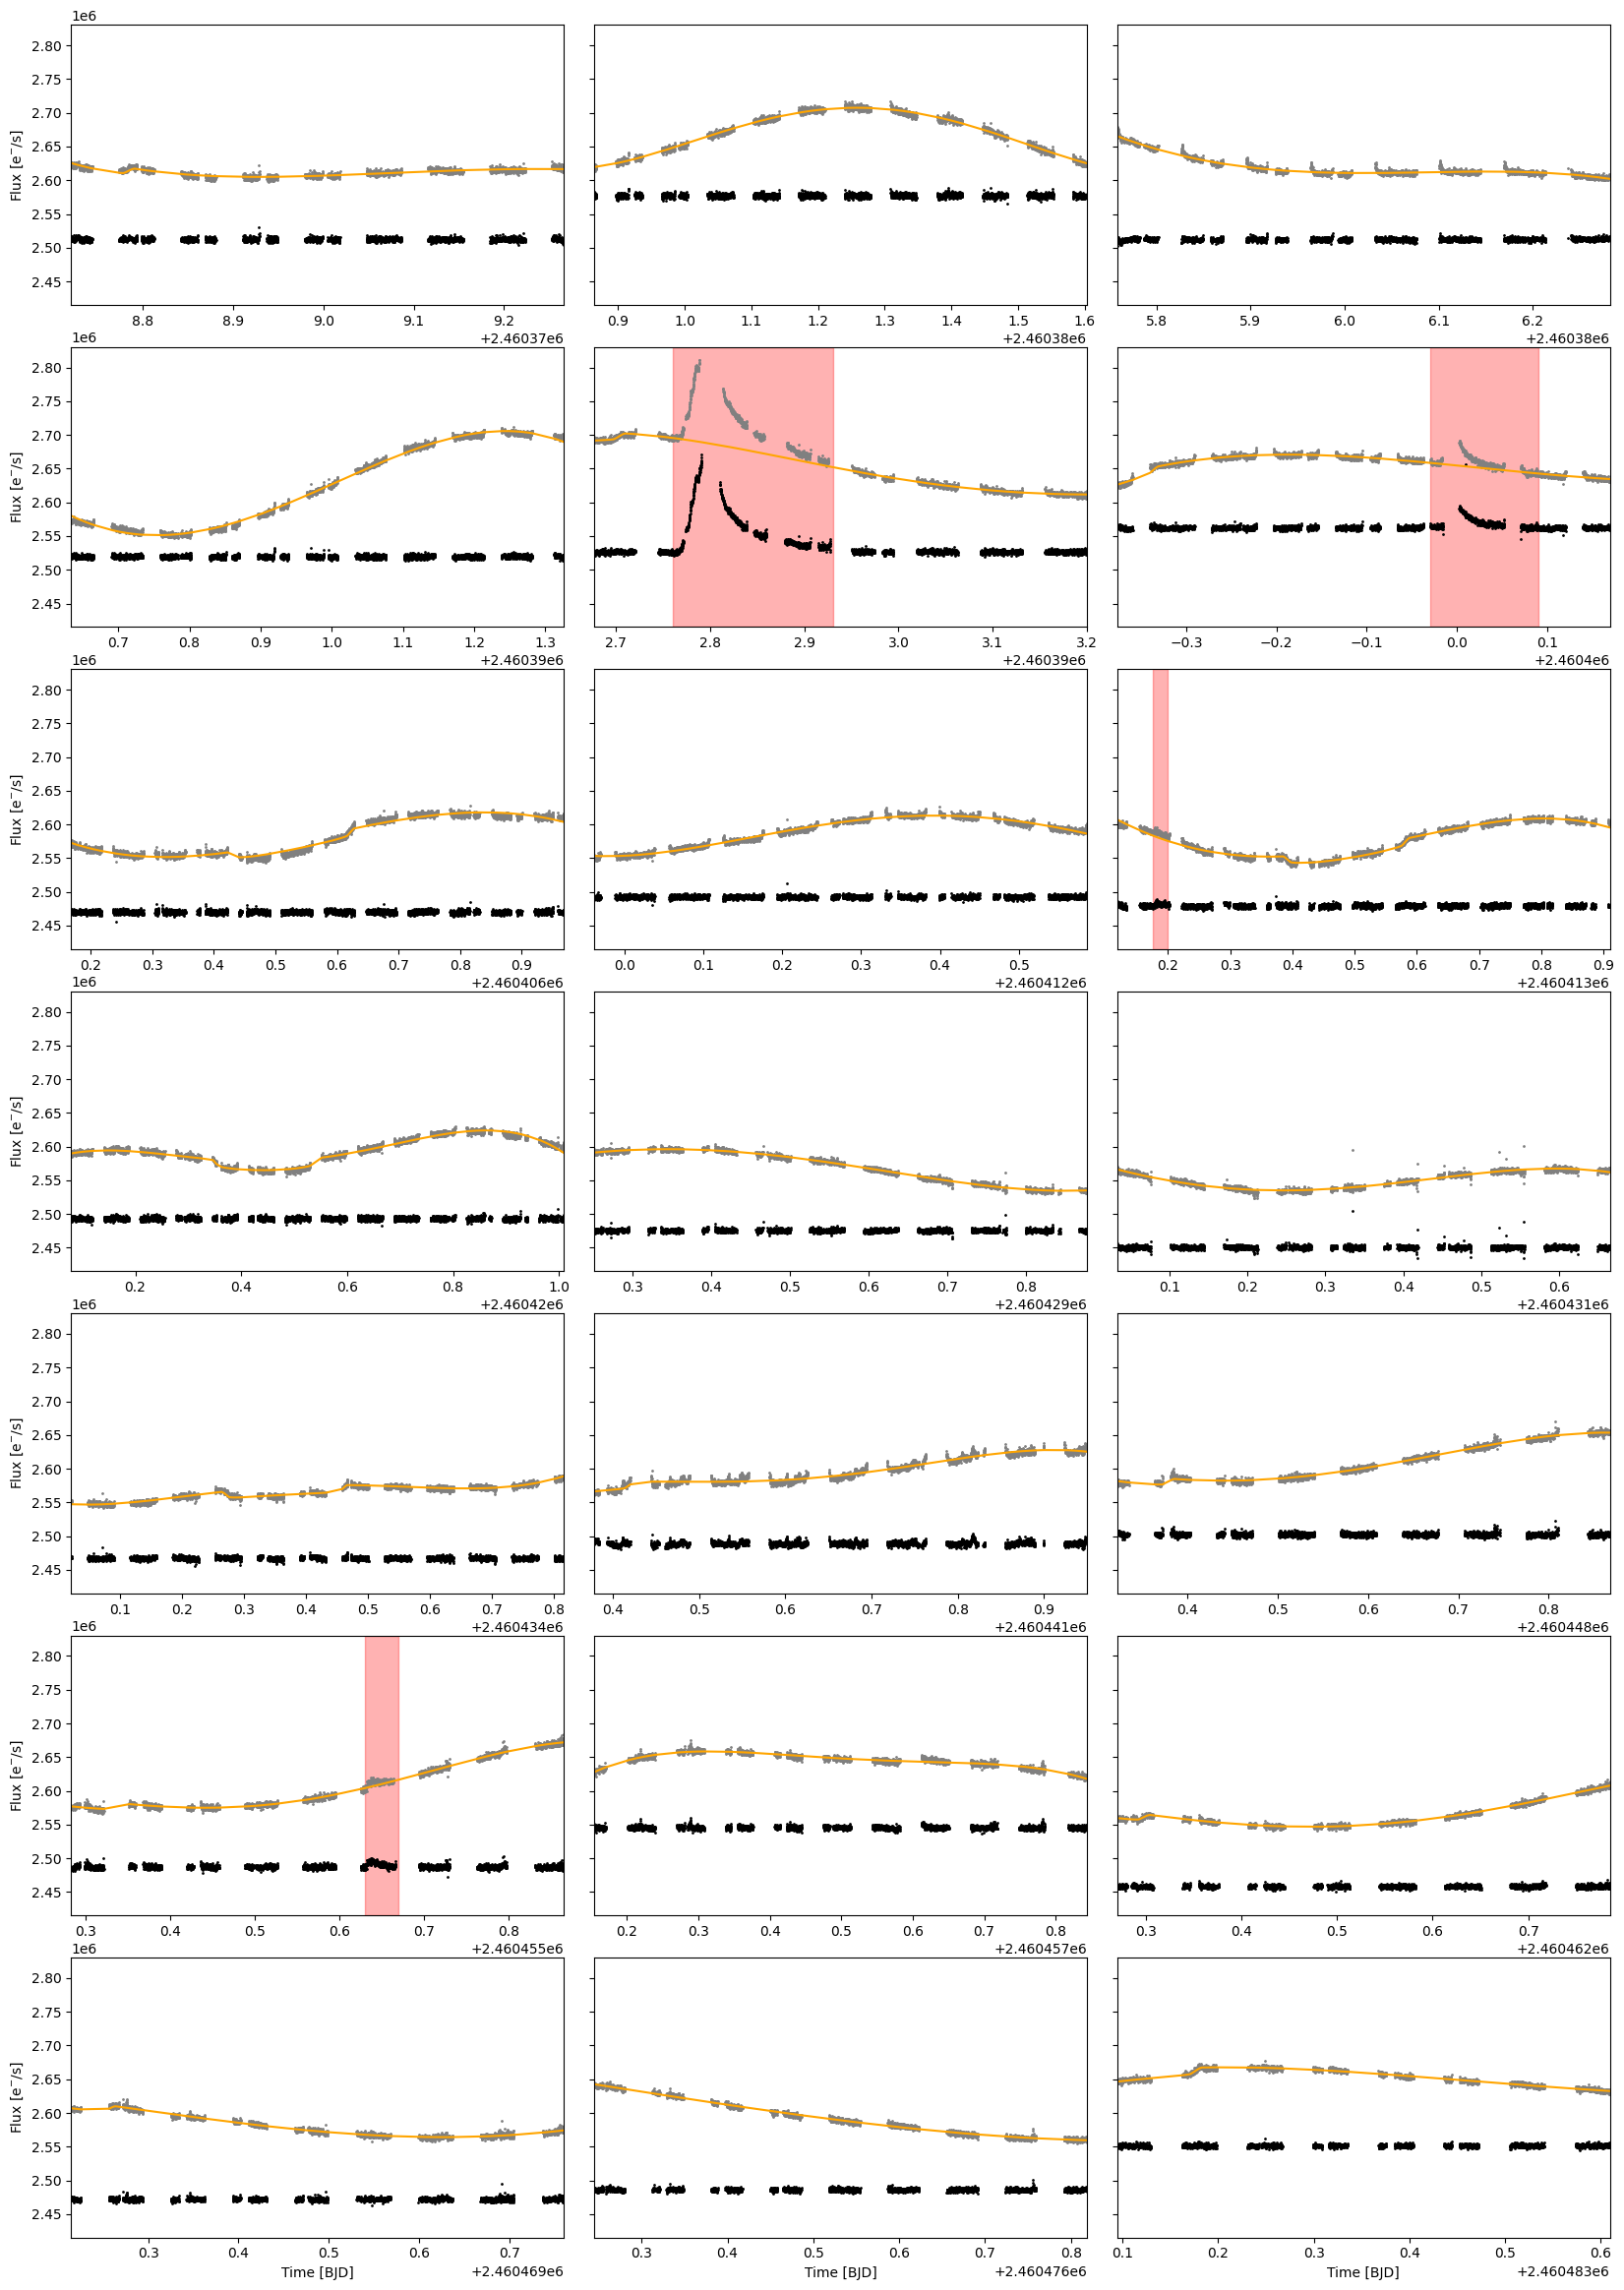

In [13]:
# make a big plot with a total of 21 subplots with two columns showing the dlcs and lcs fitting one A4 page
fig, axes = plt.subplots(7, 3, figsize=(2*8.27, 2*11.69), sharey=True)

for i, ax in enumerate(axes.flatten()):
    ax.scatter(dlcs[i]["time"], dlcs[i]["flux"], s=1, color="k", label="CHEOPS")
    ax.scatter(lcs[i-len(dlcs)]["time"], lcs[i-len(dlcs)]["flux"] + 0.1e6, s=1, color="grey", label="CHEOPS")

    # plot the model, too
    ax.plot(dlcs[i-len(dlcs)]["time"], dlcs[i-len(dlcs)]["model"] + 0.1e6, color="orange", label="Model")
        
    ax.set_xlim(dlcs[i]["time"].min(), dlcs[i]["time"].max())

    # if any of the flares in the flares table are in the time range of the light curve, mark tmin-tmax with axvspan
    for flare in flares[(flares["tmin"] > dlcs[i]["time"].min()) & (flares["tmax"] < dlcs[i]["time"].max())].iterrows():
        ax.axvspan(flare[1]["tmin"], flare[1]["tmax"], color="red", alpha=0.3, zorder=-10)


# only set y label for the first column
for ax in axes[:, 0]:
    ax.set_ylabel(flux_label)

# only set x label for the last row
for ax in axes[-1, :]:
    ax.set_xlabel(time_label)

# bring the subplots closer together
plt.tight_layout()

# reduce the vertical space between subplots
plt.subplots_adjust(hspace=0.15)

plt.savefig("../plots/paper/cheops_lc.png", dpi=300)